In [2]:
import os
import pandas as pd 
import numpy as np 
import subprocess
import math
import pickle

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KernelDensity

from scipy.stats import mannwhitneyu # Read this: https://www.statstutor.ac.uk/resources/uploaded/mannwhitney.pdf
from scipy.special import kl_div

import dataframe_image as dfi

import matplotlib.pyplot as plt 
from matplotlib.patches import Patch
import matplotlib.cm 
import matplotlib.colors 
from matplotlib.gridspec import GridSpec
plt.rcParams['font.family'] = 'Arial'

from selenobot.files import FASTAFile, fasta_file_parser_gtdb, GBFFFile, BLASTFile
from selenobot.tools import BLAST
from selenobot.organism import Organism
from selenobot.datasets import Dataset 


%load_ext autoreload 
%autoreload 2

# Make plots showing truncation ratios. 
# Look at stop codon frequency. Would be worth paying attention to the differences between Prodigal and NCBI. 
# Try training using embeddings from only the last 20 amino acids or so -- intuition that these are more important for predicting, and removes the length constraint. 

# Try grouping by chemical symbol and the genetic code hierarchy. 

# Mycobacterium is an intracellular parasite so might have a weird genome. 


In [3]:
species = ['Pseudomonas aeruginosa', 'Escherichia coli', 'Mycobacterium tuberculosis', 'Bacillus subtilis', 'Aliivibrio fischeri'] 

# Using the genomes from the GTDB species representative for release r207.
genome_ids = dict() 
genome_ids['Pseudomonas aeruginosa'] = 'GCF_001457615.1'
genome_ids['Bacillus subtilis'] = 'GCF_000009045.1'
genome_ids['Escherichia coli'] = 'GCF_000195955.2'
genome_ids['Mycobacterium tuberculosis'] = 'GCF_003697165.2'
genome_ids['Aliivibrio fischeri'] = 'GCF_016464335.1'

# genome_metadata_df = pd.read_csv('../data/gtdb_genome_metadata_bacteria.csv', index_col=0)
# genome_metadata_df = genome_metadata_df[genome_metadata_df.species.isin(species)]
# genome_metadata_df[['species', 'genome_size', 'gc_percentage']]

label_map = {'cds':'cds', 'error':'error', 'inter':'error (intergenic)', 'pseudo':'pseudogene', 'rna':'other', 'misc':'other'}
color_map = {'cds':'tab:green', 'error':'tab:red', 'error (intergenic)':'tab:red', 'pseudogene':'tab:blue', 'other':'gray'}

start_codons, stop_codons = ['ATG', 'GTG', 'TTG'], ['TAA', 'TAG', 'TGA']
color_map.update({codon:color for codon, color in zip(stop_codons, ['tab:red', 'tab:blue', 'tab:green'])})
color_map.update({codon:color for codon, color in zip(start_codons, ['tab:red', 'tab:blue', 'tab:green'])})

color_map.update({0:'gray', 1:'black'})

labels = list(label_map.values())

feature_types = ['plm_esm_gap', 'plm_pt5']
pred_col = 'binary_model_plm_esm_gap_prediction'

In [4]:
if (not os.path.exists('../data/model_organisms/organisms.pkl')):
    organisms = list()
    for species in genome_ids.keys():
        print(f'\n{species}')
        organism = Organism(genome_ids[species], species)
        organism.label()
        organisms.append(organism)
    with open('../data/model_organisms/organisms.pkl', 'wb') as f:
        pickle.dump(organisms, f)
else:
    with open('../data/model_organisms/organisms.pkl', 'rb') as f:
        organisms = pickle.load(f)

In [5]:
def load_organisms_df(labels:list=None, remove_partial:bool=True, max_seq_length:int=None, organisms:list=organisms):
    '''Load in data for all organisms, including the model predictions.'''

    df = pd.concat([organism.to_df() for organism in organisms])
    df.label = df.label.replace(label_map)
    df = df[df.label.isin(labels)] if (labels is not None) else df
    # NOTE: I think Prodigal only flags a sequence as "partial" if it runs off the end of a contig, so I think this is 
    # safe to filter... don't want to be trying to classify sequences we only have fragments of. 
    df = df[df.partial == '00'] if remove_partial else df # Really only care about the model's behavior on the complete genes. 
    df = df[df.seq.apply(len) < max_seq_length] if (max_seq_length is not None) else df

    pred_df = pd.concat([pd.read_csv(f'../data/results/gtdb_{str(organism)}.predict.csv', index_col=0) for organism in organisms])
    pred_df = pred_df[[col for col in pred_df.columns if ('prediction' in col)]]

    df = df.merge(pred_df, left_index=True, right_index=True, how='left')
        
    return df


def load_organisms_embs(feature_type:str, **kwargs):
    embs_df = []
    for organism in organisms:
        dataset = Dataset.from_hdf(f'../data/model_organisms/gtdb_{str(organism)}.h5', feature_type=feature_type, **kwargs)
        embs_df.append(dataset.to_df(add_metadata=False))
    embs_df = pd.concat(embs_df)
    return embs_df
    

In [6]:
org_df = load_organisms_df()
org_1_df = org_df[org_df[pred_col] == 1]
org_0_df = org_df[org_df[pred_col] == 0]

In [7]:
# def table_1(path='../data/model_organisms/table_01.png'):   
#     table_df = list()
#     for organism in organisms:
#         row = dict()
#         row['species'] = organism.species
#         row['GC content'] = organism.species
#         row['ref. genome size'] = organism.size(source='ncbi', pseudo=False)
#         row['GTDB genome size'] = organism.size(source='gtdb')
#         row['num. pseudogenes'] = organism.size(source='ncbi', pseudo=True)
#         row['perc. exact matches'] = f'{100 * len(organism.to_df(label='match')) / organism.size(source='gtdb'):.2f}%'
#         table_df.append(row)
#     table_df = pd.DataFrame(table_df).set_index('species')
#     dfi.export(table_df, path)

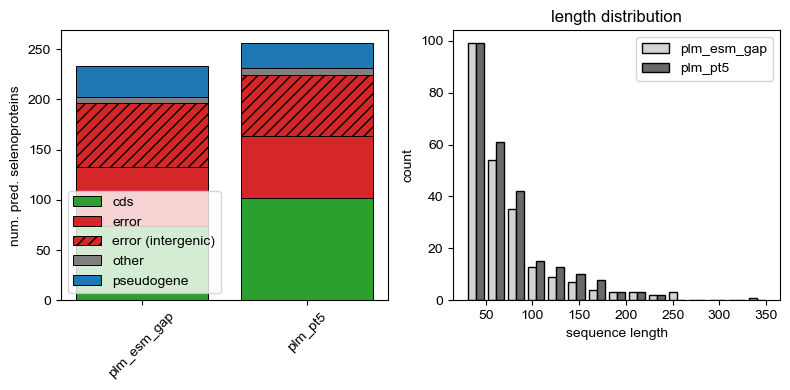

In [8]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 4))

ax = axes[0]
bottom = np.zeros(len(feature_types))
positions = np.arange(len(feature_types))

legend = []
for label, label_df in org_df.groupby('label'):
    heights = [(label_df[f'binary_model_{feature_type}_prediction'] == 1).sum() for feature_type in feature_types]
    ax.bar(positions, heights, bottom=bottom, color=color_map[label], hatch='///' if (label == 'error (intergenic)') else None, edgecolor='black', lw=0.7)
    bottom += np.array(heights)
    legend += [label]

ax.set_xticks(positions, labels=feature_types, ha='center', rotation=45)
ax.set_ylabel('num. pred. selenoproteins')
ax.legend(legend)

ax = axes[1]
hist = []
for feature_type in feature_types:
    lengths = org_df[org_df[f'binary_model_{feature_type}_prediction'] == 1].seq.apply(len)
    hist.append(lengths)
    
ax.hist(hist, bins=15, color=['lightgrey', 'dimgray'], edgecolor='black', lw=0.5)
ax.legend(feature_types)
ax.set_ylabel('count')
ax.set_xlabel('sequence length')
ax.set_title('length distribution')

plt.tight_layout()
plt.show()

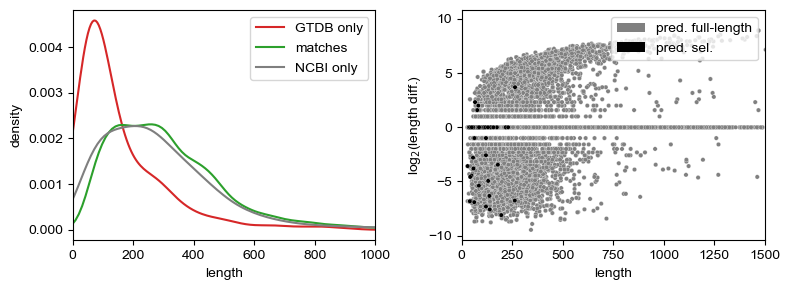

In [9]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 3))

ax = axes[0]

gtdb_df = load_organisms_df(labels=['error', 'error (intergenic)', 'pseudogene', 'other'])
both_df = load_organisms_df(labels=['cds'])
ref_df = pd.concat([organism.ref_df[organism.ref_df.feature == 'CDS'] for organism in organisms])
ref_df = ref_df[~ref_df.protein_id.isin(both_df.ref_protein_id)]
ref_df = ref_df[~ref_df.protein_id.isin(both_df.ref_protein_id)]

gtdb_df.seq.apply(len).plot.kde(ax=ax, color='tab:red')
both_df.seq.apply(len).plot.kde(ax=ax, color='tab:green')
ref_df.seq.apply(len).plot.kde(ax=ax, color='tab:gray')
ax.set_xlim(0, 1000)
ax.set_ylabel('density')
ax.set_xlabel('length')
ax.legend(['GTDB only', 'matches', 'NCBI only'])

ax = axes[1]

both_df = both_df.sort_values(pred_col)

# diffs = np.sign(both_df.length_diff) * np.log(np.abs(both_df.length_diff // 3) + 1)
# diffs = both_df.length_diff // 3
# both_df = both_df[both_df.length_diff != 0]
diffs = [0 if (d == 0) else np.sign(d) * np.log2(abs(d)) for d in (both_df.seq.apply(len) - both_df.ref_seq.apply(len)) // 3]
lengths = np.log10(both_df.ref_seq.apply(len))
lengths = both_df.seq.apply(len) 

ax.scatter(lengths, diffs, c=both_df[pred_col].replace({1:'black', 0:'gray'}), lw=0.2, s=10, edgecolors='white') 
ax.set_ylabel('log$_{2}$(length diff.)')
ax.set_xlabel('length')
ax.legend(handles=[Patch(facecolor='gray'), Patch(facecolor='black')], labels=['pred. full-length', 'pred. sel.'], loc='upper right')
ax.set_xlim(0, 1500)

plt.tight_layout()
plt.show()



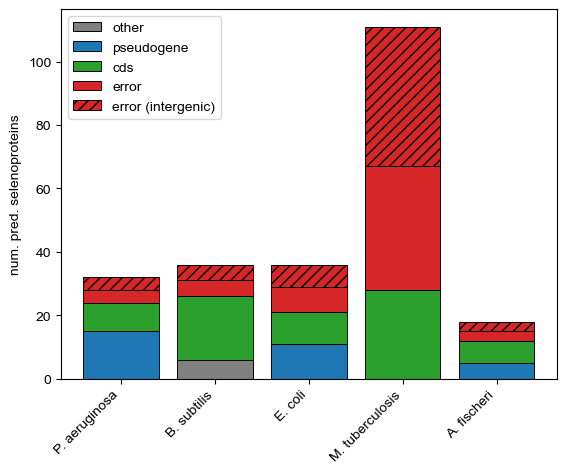

In [10]:
fig, ax = plt.subplots()

species = list(genome_ids.keys()) 

bottom = np.zeros(len(species))
for label in ['other', 'pseudogene', 'cds', 'error', 'error (intergenic)']:
    label_df = org_df[(org_df.label == label) & (org_df[pred_col] == 1)]
    # label_df = pd.concat([organism.to_df(label=label) for organism in organisms])
    heights = np.array([(label_df.species == s).sum() for s in species])
    ax.bar(np.arange(len(organisms)), heights, bottom=bottom, color=color_map[label], edgecolor='black', linewidth=0.7, hatch='///' if (label == 'error (intergenic)') else None)
    bottom += heights

ax.set_xticks(np.arange(len(organisms)), labels=[repr(organism) for organism in organisms], rotation=45, ha='right')
ax.legend(['other', 'pseudogene', 'cds', 'error', 'error (intergenic)'])
# ax.set_yscale('log')
ax.set_ylabel('num. pred. selenoproteins')
plt.show()


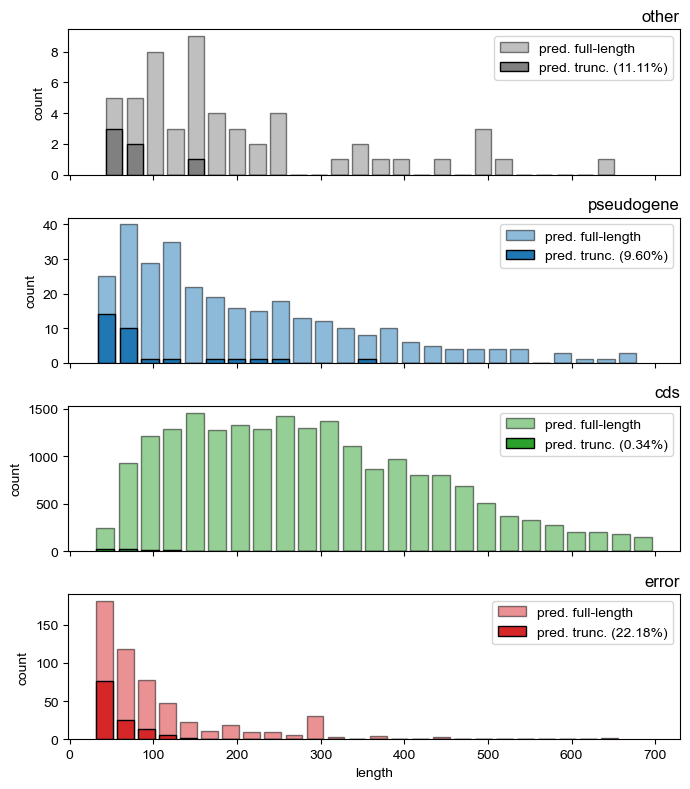

In [11]:
fig, axes = plt.subplots(nrows=4, figsize=(7, 8), sharex=True)

def figure_4(org_df:pd.DataFrame, max_seq_length:int=700, axes:list=None):

    org_df.label = org_df.label.replace({'error (intergenic)':'error'})
    org_1_df = org_df[org_df[pred_col] == 1]

    for ax, label in zip(axes, ['other', 'pseudogene', 'cds', 'error']):
        lengths = org_df[org_df.label == label].seq.apply(len)
        _, bin_edges, _, = ax.hist(lengths[lengths < max_seq_length], color=color_map[label], bins=25, rwidth=0.8, edgecolor='black', alpha=0.5)
        p = f'{100 * len(org_1_df[org_1_df.label == label]) / len(lengths):.2f}%'

        lengths = org_1_df[org_1_df.label == label].seq.apply(len) # Look only at the lengths of the predicted selenoproteins. 
        ax.hist(lengths[lengths < max_seq_length], color=color_map[label], bins=bin_edges, rwidth=0.8, edgecolor='black')

        ax.set_ylabel('count')
        ax.set_title(label, loc='right')
        ax.legend(['pred. full-length', f'pred. trunc. ({p})'])

    ax.set_xlabel('length')

figure_4(org_df, axes=axes)

plt.tight_layout()
plt.show()

# I am really curious as to why so many of the short peptides are tagged as full-length... what characteristics of the
# false positives make them false positives, other than length? It seems as though the error sequences are slightly 
# more prone to this problem, though I wonder how much of this effect is due to the fact that the error sequences tend 
# to be shorter. 

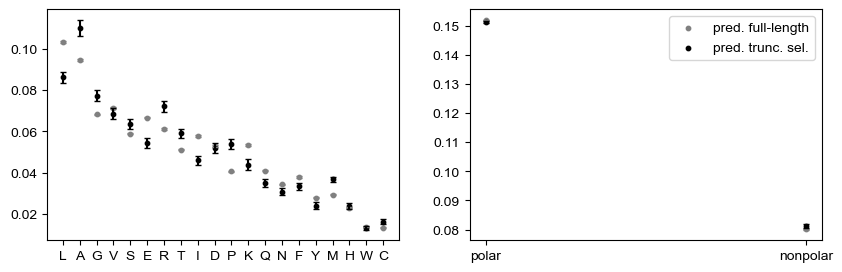

In [21]:
# First going to take a look at the spurious short sequences... what causes them to be flagged?
org_df = load_organisms_df(max_seq_length=200)
# Differences in GC content could signal differences in amino acid composition?
amino_acids = list('LAGVSERTIDPKQNFYMHWC')
bases = list('ACTG')

# From https://www.ncbi.nlm.nih.gov/Taxonomy/Utils/wprintgc.cgi?chapter=cgencodes#SG1
code_map = {'T':list('FFLLSSSSYY**CC*W'), 'C':list('LLLLPPPPHHQQRRRR'), 'A':list('IIIMTTTTNNKKSSRR'), 'G':list('VVVVAAAADDEEGGGG')}
# From https://www.imgt.org/IMGTeducation/Aide-memoire/_UK/aminoacids/IMGTclasses.html
chem_map = {'alipathic':list('AGILPV'), 'aromatic':list('FWY'), 'sulfur':list('CX'), 'hydroxyl':list('ST'), 'basic':list('RHK'), 'acidic':list('DE'), 'amine':list('NQ')}
charge_map = {'positive':list('RHK'), 'negative':list('DE'), 'uncharged':list('ANCQGILMFPSTWYV')}
polar_map = {'polar':list('RNDQEHKSTY'), 'nonpolar':list('ACGILMFPWV')}


def apply_map(seq:str, map_=dict):
    inv_map = dict()
    for key, vals in map_.items(): # Invert the map for substitution. 
        inv_map.update({val:key for val in vals})
    for a, b in inv_map.items():
        seq = seq.replace(a, b)
    return seq

x = np.arange(len(amino_acids))

fig, axes = plt.subplots(ncols=2, figsize=(10, 3))

kwargs = {'capsize':2, 'fmt':'none'}
color_map[0] = 'gray'
color_map[1] = 'black'

ax = axes[0]
for pred, df_ in org_df.groupby(pred_col):
    comps_df = pd.DataFrame([{aa:seq.count(aa) / len(seq) for aa in amino_acids} for seq in df_.seq])
    ax.errorbar(x, comps_df.mean(axis=0), yerr=comps_df.std(axis=0) / np.sqrt(len(comps_df)), c=color_map[pred], **kwargs)
    ax.scatter(x, comps_df.mean(axis=0), c=color_map[pred], s=10)
ax.set_xticks(x, labels=amino_acids)

ax = axes[1]

map_  = polar_map
cats = list(map_.keys())
x = np.arange(len(map_))

for pred, df_ in org_df.groupby(pred_col):
    seqs = [apply_map(seq, map_) for seq in df_.seq]
    comps_df = pd.DataFrame([{cat:seq.count(cat) / len(seq) for cat in cats} for seq in seqs])
    ax.errorbar(x, comps_df.mean(axis=0), yerr=comps_df.std(axis=0) / np.sqrt(len(comps_df)), c=color_map[pred], **kwargs)
    ax.scatter(x, comps_df.mean(axis=0), c=color_map[pred], s=10)
ax.set_xticks(x, labels=cats)


ax.legend(['pred. full-length', 'pred. trunc. sel.'])

plt.show()

In [19]:
# Another thing to try is to BLAST align the positive predictions with the truncated selenoproteins. 

subj_fasta_file = FASTAFile('blast_subject.fa') # All truncated selenoproteins in the training, testing, and validation datasets.
quer_fasta_file = FASTAFile('blast_query.fa') # All model organism sequences shorter than 200 amino acids in length. 
print('Number of query sequences:', len(quer_fasta_file))
print('Number of subject sequences:', len(subj_fasta_file))

# blast = BLAST()
# blast.run('blast_query.fa', 'blast_subject.fa', output_path='blast_output.tsv', make_database=False, max_high_scoring_pairs=1)

Number of query sequences: 7539
Number of subject sequences: 5810


In [ ]:
org_df = load_organisms_df(max_seq_length=200)
blast_df = BLASTFile('blast_output.tsv').to_df()

blast_n_hits = blast_df[blast_df.e_value < 1e-4].groupby('query_id').apply(len, include_groups=False)
outliers = blast_n_hits.sort_values(ascending=False)[blast_n_hits > 499].index 

# org_df[org_df.index.isin(outliers)][pred_col]


BLASTFile.load_chunks: Loading BLAST output in batches...: 100%|██████████| 151/151 [00:00<00:00, 379.36it/s]


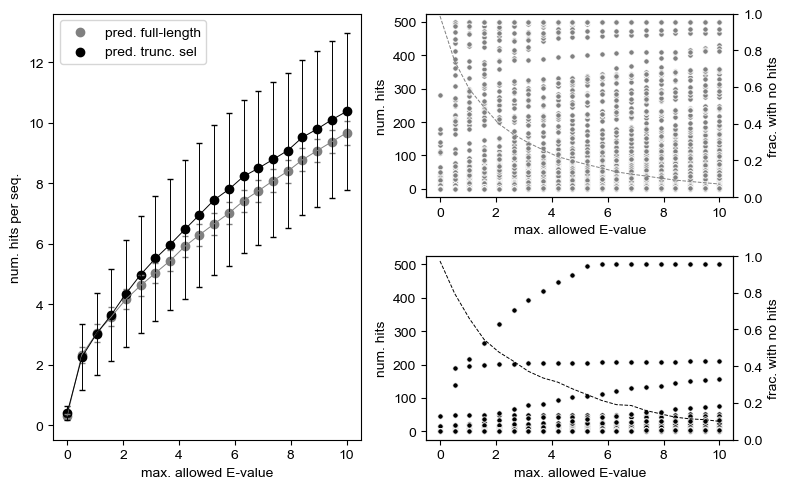

In [ ]:
fig = plt.figure(layout='tight', figsize=(8, 5))
grid = GridSpec(nrows=2, ncols=2, figure=fig)

ax_1a = fig.add_subplot(grid[:, 0])
ax_1b = [fig.add_subplot(grid[0, 1]), fig.add_subplot(grid[1, 1])]

# Remove the outliers... 
org_df = org_df[~org_df.index.isin(outliers)]

for pred, df in org_df.groupby(pred_col):
    x, y, y_err = list(), list(), list()
    for e in np.linspace(1e-4, blast_df.e_value.max(), 20):
        blast_n_hits = blast_df[blast_df.e_value < e].groupby('query_id').apply(len, include_groups=False)
        blast_n_hits.name = 'blast_n_hits'
        e_df = df.merge(blast_n_hits, left_index=True, right_index=True, how='left')
        e_df.blast_n_hits = e_df.blast_n_hits.fillna(0)

        y.append(e_df.blast_n_hits.mean())
        y_err.append(e_df.blast_n_hits.std() / np.sqrt(len(e_df)))
        x.append(e)

    ax_1a.scatter(x, y, c=color_map[pred])
    ax_1a.errorbar(x, y, yerr=y_err, c=color_map[pred], capsize=2, lw=0.7)

ax_1a.legend(['pred. full-length', 'pred. trunc. sel'])
ax_1a.set_xlabel('max. allowed E-value')
ax_1a.set_ylabel('num. hits per seq.')

for ax, (pred, df) in zip(ax_1b, org_df.groupby(pred_col)):
    x1, y1, x2, y2 = list(), list(), list(), list()
    for e in np.linspace(1e-4, blast_df.e_value.max(), 20):
        blast_n_hits = blast_df[blast_df.e_value < e].groupby('query_id').apply(len, include_groups=False)
        blast_n_hits.name = 'blast_n_hits'
        e_df = df.merge(blast_n_hits, left_index=True, right_index=True, how='left')
        e_df.blast_n_hits = e_df.blast_n_hits.fillna(0)

        x1 += [e] * len(e_df)
        y1 += e_df.blast_n_hits.values.tolist()
        x2 += [e]
        y2 += [(e_df.blast_n_hits == 0).sum() / len(e_df)]

    ax.scatter(x1, y1, s=15, edgecolors='white', lw=0.6, c=color_map[pred])
    ax.set_ylabel('num. hits')
    ax.set_xlabel('max. allowed E-value')

    right_ax = ax.twinx()
    right_ax.plot(x2, y2, color=color_map[pred], lw=0.7, ls='--')
    right_ax.set_ylabel('frac. with no hits')
    right_ax.set_ylim(0, 1)

plt.show()





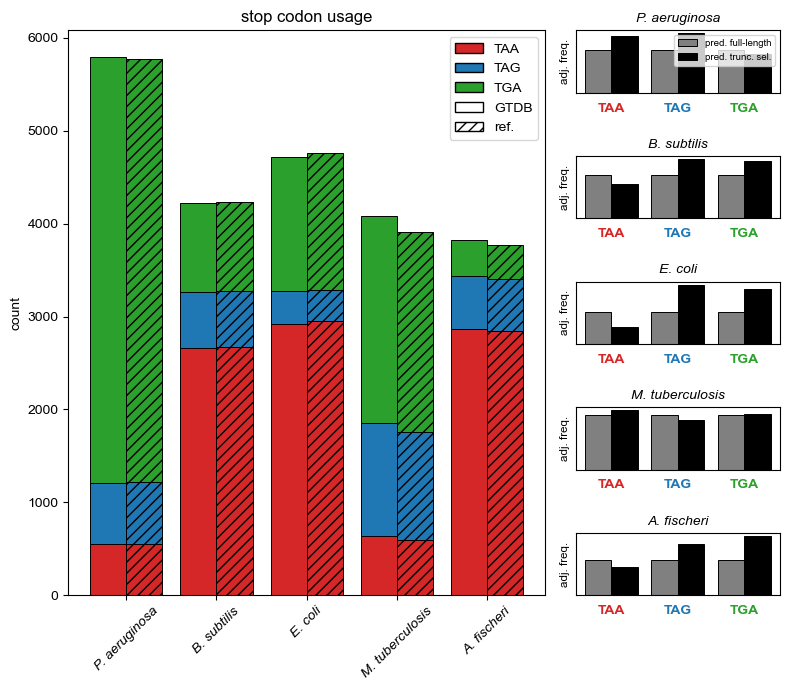

In [89]:
fig = plt.figure(layout='tight', figsize=(8, 7))
grid = GridSpec(nrows=5, ncols=2, figure=fig, width_ratios=[0.7, 0.3])

ax_1a = fig.add_subplot(grid[:, 0])
ax_1b = [fig.add_subplot(grid[i, 1]) for i in range(5)]

start

def figure_5(codon_type:str='start'):

    codons = {'start':['ATG', 'GTG', 'TTG'], 'stop':['TAA', 'TAG', 'TGA']}
    codons = codons[codon_type]

    df = pd.concat([organism.df.value_counts(f'{codon_type}_codon').sort_index() for organism in organisms], axis=1)
    df = df[~(df.index == 'none')]

    ref_df = pd.concat([organism.ref_df[organism.ref_df.feature == 'CDS'].value_counts('stop_codon').sort_index() for organism in organisms], axis=1)
    ref_df = ref_df[~(ref_df.index == 'none')]

    def add_bar(heights:np.ndarray=None, bottom:np.ndarray=None, ax:plt.Axes=None, offset:float=0, positions:np.ndarray=None, **kwargs):
        ax.bar(positions - offset, heights, bottom=bottom, edgecolor='black', lw=0.7, width=0.4, **kwargs)
        if bottom is not None:
            return bottom + heights

    def add_colored_xtick_labels(ticks:np.ndarray, labels:list=None, colors:list=None, ax:plt.Axes=None, **kwargs):
        ax.set_xticks([])
        for x, label, color in zip(ticks, labels, colors):
            ax.text(x, -0.3, label, color=color, ha='center', transform=ax.get_xaxis_transform(), **kwargs)

    positions = np.arange(len(organisms))
    bottom = np.zeros(len(organisms))
    for codon, heights in zip(df.index, df.values):
        bottom = add_bar(positions=positions, bottom=bottom, heights=heights, ax=ax_1a, offset=0.2, color=color_map[codon])

    bottom = np.zeros(len(organisms))
    for codon, heights in zip(ref_df.index, ref_df.values):
        bottom = add_bar(positions=positions, bottom=bottom, heights=heights, ax=ax_1a, offset=-0.2, color=color_map[codon], hatch='///')

    handles = [Patch(facecolor=color_map[codon], edgecolor='black') for codon in codons] + [Patch(facecolor='white', edgecolor='black'), Patch(facecolor='white', hatch='///', edgecolor='black')]
    ax_1a.legend(handles=handles, labels=codons + ['GTDB', 'ref.'])
    ax_1a.set_xticks(positions, labels=[repr(organism) for organism in organisms], rotation=45, fontstyle='italic')
    ax_1a.set_title(f'{codon_type} codon usage')
    ax_1a.set_ylabel('count')

    positions = np.arange(len(codons))

    for ax, organism in zip(ax_1b, organisms):
        ax.set_title(repr(organism), fontsize='medium', fontstyle='italic')
        ax.set_ylabel('adj. freq.', fontsize='small')
        ax.set_yticks([])
        add_colored_xtick_labels(positions, labels=codons, colors=[color_map[codon] for codon in codons], fontweight='bold', fontsize='medium', ax=ax)

        org_df = load_organisms_df(organisms=[organism])
        totals = {codon:(org_df[f'{codon_type}_codon'] == codon).sum() for codon in codons}

        for pred, df in org_df.groupby(pred_col):
            heights = np.array([(df[f'{codon_type}_codon'] == codon).sum() / totals[codon] for codon in codons]) / len(df) 
            add_bar(positions=positions, heights=heights, ax=ax, color=color_map[pred], offset=0.2 if (pred == 0) else -0.2)
    ax_1b[0].legend(['pred. full-length', 'pred. trunc. sel.'], fontsize='x-small')

    plt.show()

figure_5(codon_type='stop')

In [25]:
# What if we just look at stop codon usage in the errors? Compare those which are predicted selenoproteins versus not. 
# I'm not sure if we can avoid separating by organism, as it could be skewed by the stop codon usage in different organisms, 
# and the fact that some organisms just have more predicted selenoproteins for a non-stop codon related reason. OR, it could 
# be that the reason some organisms have more predicted selenoproteins is due to their increased UGA stop codon usage. 

# org_df = load_organisms_df(labels=['error', 'error (intergenic)'])
# for pred, df in org_df.groupby(pred_col):
#     # Why do so many of these not have a valid stop or start codon? Ah I am messing up the strand somehow. 
#     print(pred)
#     print(df.value_counts('stop_codon') / len(df))

# org_df = load_organisms_df(labels=['cds'])
# for pred, df in org_df.groupby(pred_col):
#     # Why do so many of these not have a valid stop or start codon? Ah I am messing up the strand somehow. 
#     print(pred)
#     print(df.value_counts('stop_codon') / len(df))

In [37]:
# Last thing I can think of to do is look at the logits for the predicted selenoproteins. 

def softmax(row):
    row = np.exp(row - np.max(row))
    return row / row.sum()

org_df = load_organisms_df(max_seq_length=200) # Load only short sequences...

# Debating what the best way to pre-process this data is. Logits are just the unnormalized model outputs. 
# Options are to apply a softmax and trat the outputs as you would a classifier (look at the probabilities). 
# For this, need to additionally apply a log scale; even after removing the EOS token, the probabilities of the
# different amino acids still varies too wildly to get much of a signal. 
embs = load_organisms_embs(feature_type='plm_esm_log', aa_tokens_only=True)
# embs = pd.DataFrame(scaler.fit_transform(embs.values), index=embs.index, columns=Dataset.aa_tokens)
embs.columns = Dataset.aa_tokens
# scaler = StandardScaler()

embs = embs.iloc[:, 1:].apply(softmax, axis=1) 
# embs = embs.apply(np.log10)

embs, org_df = embs.align(org_df, join='inner', axis=0) # This will basically filter by length. 
embs_1 = embs[org_df[pred_col] == 1].copy()# .iloc[:, 1:]
embs_0 = embs[org_df[pred_col] == 0].copy() # .iloc[:, 1:]


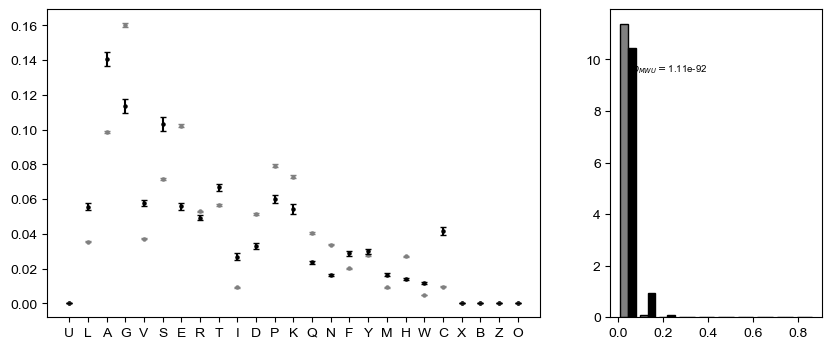

In [43]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), width_ratios=[0.7, 0.3])

ax = axes[0]
# x = np.arange(len(Dataset.aa_tokens[1:]))
x = np.arange(len(embs.columns))
for pred, embs_ in enumerate([embs_0, embs_1]):
    # embs_ = embs_.iloc[:, 1:] # Remove the EOS token signal.
    y = embs_.mean(axis=0)
    y_err = embs_.std(axis=0) / np.sqrt(len(embs_))
    ax.scatter(x, y, c=color_map[pred], s=5)
    ax.errorbar(x, y, yerr=y_err, capsize=2, linestyle='', color=color_map[pred])
# ax.set_xticks(x, Dataset.aa_tokens[1:])
ax.set_xticks(x, embs.columns)
ax.legend(['pred. full-length', 'pred. trunc. sel.'])


ax = axes[1]
# I wonder if there is any signal for selenocysteine? Look at the distribution of probability differences for each residue, maybe. 
# Maybe should look how far the output for U is from the mean?

# NOTE: Not sure if this is the right thing to do here, maybe look at the raw output instead? I wanted to control for the fact
# that probabilities for non-EOS tokens are generally higher in the predicted selenoprotein case due to differences in the EOS token prediction. 

# TODO: Find out if ESM is trained with selenocysteines in the dataset, or are these masked? I know that rare amino acids, U included, are masked with X
# in the Prot-T5 model, but can't find anything about ESM. 

def get_dist(aa:str, embs:pd.DataFrame):
    aa_idx = list(embs.columns).index(aa) # Get the amino acid column index. Includes the EOS token
    # This value should be more positive if the predicted residue probability is higher. 
    # dist = np.array([emb[aa_idx] - emb[1:].mean() for emb in embs.values]) # Don't include EOS token in the mean. 
    dist = np.array([emb[aa_idx] for emb in embs.values]) # Don't include EOS token in the mean. 
    return dist

def get_mwu(aa:str, embs:list):
    # Expect the first distribution in the list to be the full-length distribution. 
    dists = [get_dist(aa, embs_) for embs_ in embs]
    res = mannwhitneyu(*dists, alternative='less')
    return res, {'aa':aa, 'p':res.pvalue, 'u':res.statistic}

# Could apply a either KL divergence or Mann-Whitney U, both of which work in non-parametric cases.
# alternative='less' means testing if the first distribution X is less than the second distribution Y.
aa = 'C'
dists = [get_dist(aa, embs_0), get_dist(aa, embs_1)]
res, _ = get_mwu(aa, [embs_0, embs_1])
ax.hist(dists, density=True, color=['gray', 'black'], edgecolor='black')
ax.text(0.1, 0.8, '$p_{MWU}=$' + f'{res.pvalue:.2e}', transform=ax.transAxes, fontsize='x-small')

plt.show()

In [41]:
df = pd.DataFrame([get_mwu(aa, [embs_0, embs_1])[1] for aa in embs.columns]).set_index('aa')

In [42]:
df.sort_values('p')

,p,u
aa,,
C,1.105041e-92,165242.5
X,3.176682e-75,231761.0
W,2.695587e-60,295246.0
I,7.006888e-58,306247.0
V,1.671354e-34,428248.0
M,9.608302e-34,432849.0
L,1.075320e-33,433147.0
A,2.429433e-29,460661.0
S,1.010016e-25,485219.0
